In [1]:
import numpy as np

In [2]:
1.5*1e-4 + np.array([0.0402, 0.0519, 0.0660])

array([0.040279, 0.051979, 0.066079])

In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = ''
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
os.environ['JAX_PLATFORMS'] = 'cpu'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_qtt
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve, llt_inv_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot, CorrectionNet, ShiftNet

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

plt.rcParams['figure.figsize'] = (11, 7)

# Setup experiment

In [12]:
pde = 'div_k_grad'      # 'poisson', 'div_k_grad'
grid = 64            # 32, 64, 128
variance = .1        # 0.1, 0.5, 1.0 1.5
lhs_type = 'fd'      # 'fd', 'ilu0', 'ilu1', 'ilu2', 'ict', 'l_ict', 'a_pow'
N_train = 1000
N_test = 200


fill_factor = 1     # int
threshold = 1e-4     # float
power = 2            # int
N_valid_CG = 100     # Number of CG iterations for validation in the very end

In [13]:
with_cond = False
layer_ = Conv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
alpha = jnp.array([0.])

loss_type = 'llt'               # 'llt', 'llt-res', 'inv-prec'

In [14]:
batch_size = 16
epoch_num = 700
lr = 1e-3
schedule_params = None #[1700, 2001, 300, 1e-1]    # [start, stop, step, decay_size]

In [15]:
# if (loss_type in {'notay', 'llt-res', 'llt-res-norm'} and dataset == 'simple') or (loss_type in {'llt', 'llt-norm'} and dataset == 'krylov'):
#     raise ValueError('Not valid dataset for a chosen loss')

if schedule_params != None:
    assert len(schedule_params) == 4
    
    start, stop, step, decay_size = schedule_params
    steps_per_batch = N_train // batch_size
    start, stop, step = start*steps_per_batch, stop*steps_per_batch, step*steps_per_batch
    lr = optax.piecewise_constant_schedule(
        lr,
        {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
    )

In [16]:
model_config = {
    'node_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_dec': {
        'features': [16, 16, 1],
        'N_layers': 2,
        'layer_': layer_
    },
    'mp': {
        'edge_upd': {
            'features': [48, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'node_upd': {
            'features': [32, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'mp_rounds': 5
    }
}

# Make dataset

In [17]:
s1 = perf_counter()
A_train, A_pad_train, b_train, u_exact_train, bi_edges_train = dataset_qtt(pde, grid, variance, lhs_type, return_train=True, N_samples=N_train, fill_factor=fill_factor, threshold=threshold, power=power)
A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = dataset_qtt(pde, grid, variance, lhs_type, return_train=False, N_samples=N_test, fill_factor=fill_factor, threshold=threshold, power=power)
print(perf_counter() - s1)

1.285313343629241


In [18]:
from utils import jBCOO_to_scipyCSR
import ilupp

N = A_train.shape[0]
time_ls = []

for n in range(N):
    A_n = jBCOO_to_scipyCSR(A_train[n, ...])
    
    t_s = perf_counter()
    L = ilupp.ichol0(A_n)
    time_ls.append(perf_counter() - t_s)
print(f'mean = {np.mean(time_ls):.6f}, std = {np.std(time_ls):.6f}')

mean = 0.000154, std = 0.000012


In [10]:
from scipy.sparse.linalg import LinearOperator, cg, spsolve_triangular
import pyamg
from scipy.sparse import tril
from utils import jBCOO_to_scipyCSR
from jax import random
from tqdm import trange

def run_all_test_AMG(A, b, atol):
    amg_iters = []
    amg_p_time = []
    amg_cg_time = []
    
    for i in trange(A.shape[0]):
        iters = 0
        def nonlocal_iterate(arr):
            nonlocal iters
            iters += 1
        
        A_i, b_i = jBCOO_to_scipyCSR(A[i, ...]).astype(np.float32), np.asarray(b[i, ...]).astype(np.float32)
        
        t_prec = perf_counter()
        ml = pyamg.aggregation.smoothed_aggregation_solver(A_i)
        M_i = ml.aspreconditioner(cycle='V')
        amg_p_time.append(perf_counter() - t_prec)
        
        t_cg = perf_counter()
        solution, info = cg(A_i, b_i, M=M_i, callback=nonlocal_iterate, rtol=1e-30, atol=atol, maxiter=1000, x0=np.array(random.normal(random.PRNGKey(42), b_i.shape)))
        amg_cg_time.append(perf_counter() - t_cg)
        
        amg_iters.append(iters)
    return amg_iters, amg_p_time, amg_cg_time

In [11]:
for atol in [1e-3, 1e-6, 1e-9]:
    amg_iters, amg_p_time, amg_cg_time = run_all_test_AMG(A_test, b_test, atol)
    print(f'atol = {atol}')
    print(f'AMG\n  iters\n   mean = {np.mean(amg_iters):.4f}, std = {np.std(amg_iters):.4f}\n  time prec\n   mean = {np.mean(amg_p_time):.4f}, std = {np.std(amg_p_time):.4f}')
    print(f'  time cg\n   mean = {np.mean(amg_cg_time):.4f}, std = {np.std(amg_cg_time):.4f}')
    print()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.67it/s]


atol = 0.001
AMG
  iters
   mean = 8.6250, std = 0.4841
  time prec
   mean = 0.0566, std = 0.0062
  time cg
   mean = 0.0336, std = 0.0216



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 194/200 [00:20<00:00,  9.34it/s]


KeyboardInterrupt: 

In [ ]:
from pyamg.aggregation import smoothed_aggregation_solver
from pyamg.gallery import poisson
from scipy.sparse.linalg import cg
import scipy as sp

for i in range(A_test.shape[0]):
    A_i = A_test[0 ...]
    A = poisson((100, 100), format='csr')
    b = np.random.rand(A.shape[0])
    ml = smoothed_aggregation_solver(A)
    M = ml.aspreconditioner(cycle='V')
    x, info = cg(A, b, tol=1e-8, maxiter=30, M=M)

In [75]:
import pyamg
import numpy as np
from utils import jBCOO_to_scipyCSR

iters = 0
def nonlocal_iterate(arr):
    global iters
    iters += 1

A = jBCOO_to_scipyCSR(A_test[0, ...])#.astype(np.float32)
b = np.asarray(b_test[0, ...])#.astype(np.float32)
    
ml = pyamg.smoothed_aggregation_solver(A=A)
accelerated_residuals = []
x = ml.solve(b, tol=1e-15, accel='cg', residuals=accelerated_residuals, callback=nonlocal_iterate)
print(iters)
print(accelerated_residuals[-1])

# ml = pyamg.ruge_stuben_solver(A)
# print(ml)

# atol = 1e-9*jnp.linalg.norm(b)
# print('atol:', atol)
# x, info = ml.solve(b, tol=1e-9, maxiter=1000, return_info=True, callback=nonlocal_iterate, x0=np.array(random.normal(random.PRNGKey(42), b.shape)))
# print("residual: ", np.linalg.norm(b-A*x))
# iters

15
5.85840734947895e-14


In [1]:
0.470 + 8.6*1e-2

0.5559999999999999

In [2]:
1.233/0.56

2.2017857142857142

In [12]:
A_train

BCOO(float32[1000, 16384, 16384], nse=81408, n_batch=1)

In [9]:
# A_pad_train[80, ...].indices[300, :]

In [10]:
# plt.rcParams['figure.figsize'] = (11, 7)
# start, stop = 300, 350
# start_im = 45
# stop_im = start_im + 64

# for j, ind in enumerate(bi_edges_train[80, start:stop, :]):
#     A_loc = A_pad_train[80, ...]
#     A_loc.data = A_loc.data * 0 + 1
#     A_loc.data = A_loc.data.at[ind].set(5)
#     plt.imshow(A_loc[start_im:stop_im, start_im:stop_im].todense())
#     plt.axis(False)
#     plt.show()
    
#     if j == 64: break

# Train model

In [76]:
seed = 42
NodeEncoder = FullyConnectedNet(**model_config['node_enc'], key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(**model_config['edge_enc'], key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(**model_config['edge_dec'], key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(**model_config['mp']['edge_upd'], key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(**model_config['mp']['node_upd'], key=random.PRNGKey(seed)),
    mp_rounds=model_config['mp']['mp_rounds']
)

# model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)


model = CorrectionNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, alpha=alpha)

# w = jnp.zeros(A_pad_train[0, ...].nse)
# b = alpha
# model = ShiftNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, w=w, b=b)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2754


In [77]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train],
    [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size,
}

In [93]:
def calc_forward_call(model, X, y, repeats=100):
    '''Placeholder for supervised learning `y`.
       Positions in `X`:
         X[0] - lhs A (for cond calc).
         X[1] - padded lhs A (for training).
         X[2] - rhs b.
         X[3] - indices of bi-directional edges in the graph.
         X[4] - solution of linear system x.
     '''
    nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(X[1], X[2])
    lhs_nodes, lhs_edges, lhs_receivers, lhs_senders, _ = direc_graph_from_linear_system_sparse(X[0], X[2])
    
    time_ls = []
    for I in range(repeats):
        t_s = perf_counter()
        L = model((nodes[0, ...], edges[0, ...], receivers[0, ...], senders[0, ...]), X[3][0, ...], (lhs_nodes[0, ...], lhs_edges[0, ...], lhs_receivers[0, ...], lhs_senders[0, ...]))
        time_ls.append(perf_counter() - t_s)
    return time_ls

time_ls = calc_forward_call(model, data[0], data[2], 1000)

In [94]:
np.round(np.mean(time_ls), 4), np.round(np.std(time_ls), 4)

(0.5499, 0.0231)

In [96]:
1.233 / 0.560

2.2017857142857142

In [3]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, repeat_step=1, with_cond=with_cond)
dt = perf_counter() - s

NameError: name 'model' is not defined

In [ ]:
dt

In [ ]:
print('alpha:', end='')
model.alpha

In [ ]:
# print('w:', end='')
# print(model.w)
# print('b:', end='')
# model.b

In [ ]:
nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad_test, b_test)
lhs_nodes, lhs_edges, lhs_receivers, lhs_senders, _ = direc_graph_from_linear_system_sparse(A_test, b_test)

L = vmap(model, in_axes=((0, 0, 0, 0), 0, (0, 0, 0, 0)), out_axes=(0))((nodes, edges, receivers, senders), bi_edges_test, (lhs_nodes, lhs_edges, lhs_receivers, lhs_senders))
del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
clear_caches()

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

In [ ]:
import ilupp
from utils import jBCOO_to_scipyCSR, asses_cond_with_res
import jax.experimental.sparse as jsparse

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=L[0, ...][None, ...]))
print('Approx cond with constructed:', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=jsparse.BCOO.from_scipy_sparse(ilupp.ichol0(jBCOO_to_scipyCSR(A_test[0, ...])))[None, ...]))
print('Approx cond with IC(0):      ', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

# Apply model to CG

In [23]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=None, seed=42)

In [24]:
if loss_type != 'inv-prec':
    # P = LL^T
    prec = partial(llt_prec_trig_solve, L=L)
else:
    # P^{-1} = LL^T
    prec = partial(llt_inv_prec, L=L)

s_prec = perf_counter()
X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=prec, seed=42)
print(perf_counter() - s_prec)

79.2555962339975


In [25]:
# print(A_pad_test.shape)
# a = A_pad_test[0, :100, :100]
# a.data = a.data * 0 + 1
# plt.imshow(a.todense())

In [11]:
1.2331 + 6.9 * 1e-4

1.2337900000000002

 CG: {0.001: nan, 1e-06: nan, 1e-09: nan, 1e-12: nan}
PCG: {0.001: nan, 1e-06: nan, 1e-09: nan, 1e-12: nan}


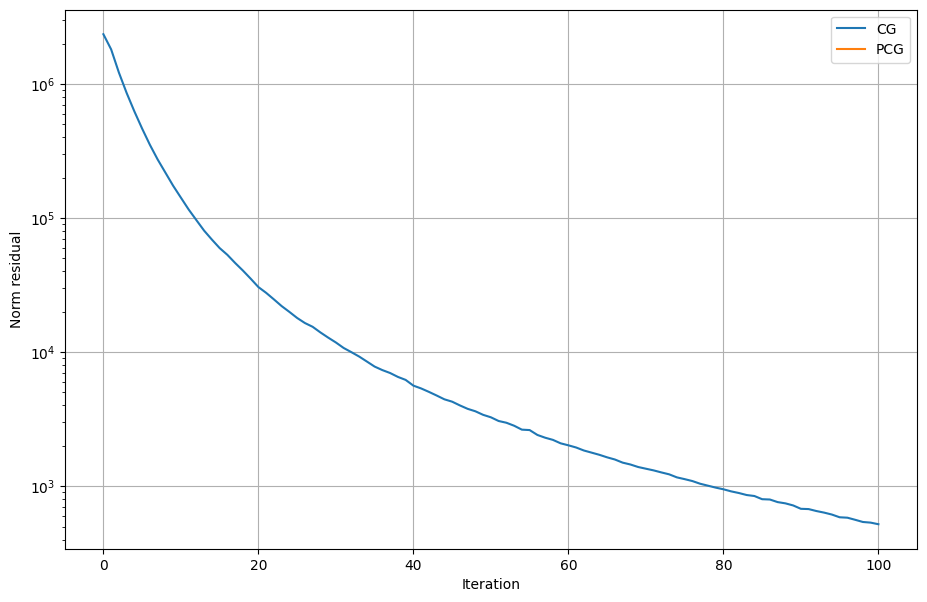

In [26]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="CG")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="PCG")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();
    
res_I_dict = iter_per_residual(jnp.linalg.norm(R_I, axis=1).mean(0))
res_LLT_dict = iter_per_residual(jnp.linalg.norm(R_LLT, axis=1).mean(0))
print(' CG:', res_I_dict)
print('PCG:', res_LLT_dict)

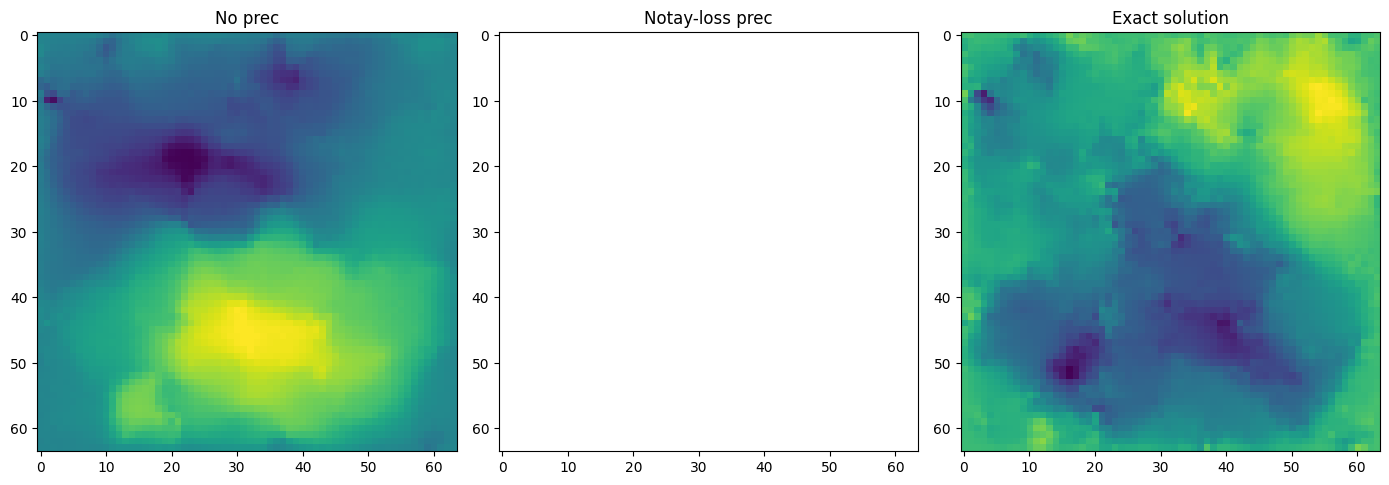

In [27]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()